# Imports and settings

In [1]:
import numpy as np
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
%matplotlib inline 
import os.path
import json
import scipy
import argparse
import math
import utils
import test
import pickle
import pylab
import cv2
from sklearn.preprocessing import normalize
caffe_root = '/storage/plzen1/home/gogartom/caffe-segnet/'                # Change this to the absolute directoy to SegNet Caffe
import sys
import caffe

import ipywidgets as widgets
from IPython import display as disp 

In [24]:
plt.rcParams['figure.figsize'] = (25, 25)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

split_num = 8
experiment='v4'

model = '../models/'+experiment+'_inference.prototxt'
weights = '../models/snapshots/'+experiment+'/snapshot_split_'+str(split_num)+'_10000.caffemodel'
dataset = '../data_shops/page_sets/splits/split_'+str(split_num)+'_test.txt'
# dataset = '../data_shops/page_sets/www.champssports.com.txt'


caffe.set_mode_gpu()
net = caffe.Net(model,
                weights,
                caffe.TEST)

net.layers[0].set_data(dataset)

position_maps = utils.load_position_maps(str(split_num), 80)

Loading data from: ../data_shops/page_sets/splits/split_8_test.txt
Loading position maps smoothed with Gausian filter, sigma= 80


# Display methods

In [25]:
def next_image():
    net.forward()
    
def get_image():
    image = net.blobs['im_data'].data     
    image = np.squeeze(image[0,:,:,:])
    image = image/255.0
    image = np.transpose(image, (1,2,0))
    image = image[:,:,(2,1,0)]
    return image

def get_boxes():
    boxes = net.blobs['boxes'].data[:,1:5]
    return boxes
    
###--- Displays activations of convolutional layers (incl. pools and norms)
def display_conv_activations(selected_layer, selected_neuron):
    ### clear previous
    disp.clear_output(wait=True)

    ### Get activations 
    layer_activations = net.blobs[selected_layer].data[0]
    
    ### Convert BGR image to RGB
    im = get_image()
    im_orig_shape = im.shape

    ### Get activations
    activations = layer_activations[selected_neuron] #135 #169
    
    act_x_ratio =  im.shape[1]/activations.shape[1]
    act_y_ratio =  im.shape[0]/activations.shape[0]
    
    activations = np.kron(activations, np.ones((act_y_ratio,act_x_ratio)))
    
    im_ratio =  activations.shape[1]*1.0/ im.shape[1]
    im = scipy.ndimage.zoom(im, im_ratio, order=0)

    ## DISPLAY
    #-- image
    plt.imshow(im) 
      
    #-- activations
    plt.imshow(activations, alpha=0.6) 
    
    #-- boxes
    boxes = get_boxes()
    for box in boxes:
        rect = plt.Rectangle((box[0], box[1]), box[2] - box[0],
                      box[3] - box[1], fill=False, edgecolor='black', linewidth=2)
        plt.gca().add_patch(rect)


def show_activation(selected_layer):
    disp.clear_output(wait=True)
    print selected_layer
    columns = 3
    num_of_neurons = len(net.blobs[selected_layer].data[0])
    lines = int(math.ceil(num_of_neurons*1.0/columns))

    box_id = 0
    layer_activations = net.blobs[selected_layer].data[box_id]
    print layer_activations.shape
    
#     plt.subplots_adjust(left=0, bottom=0, right=1, top=16, wspace=0, hspace=0.1)
#     for i in range(num_of_neurons):
#         ax = plt.subplot(lines, columns,i+1)
#         ax.set_axis_off()
#         ax.set_title(str(i))
#         ax.imshow(layer_activations[i])

#     plt.show()

    ax = plt.gca()
    ax.set_autoscaley_on(False)
    ax.set_autoscalex_on(False)
    ax.set_ylim([0,lines])
    ax.set_xlim([0,columns])
    ind = 0
    plt.rcParams['figure.figsize'] = (55, 30)
    
#     for row in range(lines):
#         for col in range(columns):
    for ind in range(num_of_neurons):
        row = ind/columns
        col = ind-(row*columns)
        patch = layer_activations[ind]
        ax.imshow(patch, extent=[col,col+1,row,row+1])
        plt.text(col, row,str(ind),fontsize='16',color='g')
        ind+=1
        
def display_results(display_input_boxes, display_gt, display_classified, with_position):
    disp.clear_output(wait=True)
    plt.rcParams['figure.figsize'] = (25, 25)
    
    predicted = net.blobs['prob'].data[:,0:4,0,0]  #(n_boxes,n_classes)
    boxes = net.blobs['boxes'].data[:,1:5]         #(n_boxes, 4)
    
    if with_position:
        predicted = test.get_probabilities_with_position(boxes, predicted, position_maps) #[:,1:4]
    
    # get image for plt
    image = get_image()

    # show image
    plt.imshow(image,vmin=0, vmax=1)
    
    # get class for each element (n_boxes,)
    box_class = np.argmax(predicted,axis=1)
     
    # find boxes with highest probability
    max_boxes = np.argmax(predicted,axis=0)
    
    colors = ['r','g','b']
    
    # for each class
    for cls in range(1,4):
        #-- get max box
        ind = max_boxes[cls]
        pred_box = boxes[ind,:]
        
        #-- plot max box
        rect = plt.Rectangle((pred_box[0], pred_box[1]), pred_box[2] - pred_box[0],
                      pred_box[3] - pred_box[1], fill=True, alpha=0.5,facecolor=colors[cls-1],
                             edgecolor=colors[cls-1], linewidth=5)
        plt.gca().add_patch(rect)
        
        #-- plot other classified boxes
        # for each box in this class -> plot them
        if display_classified:
            for box_ind in np.where(box_class==cls)[0]:
                box = boxes[box_ind,:]
                prob = predicted[box_ind,cls]
                rect = plt.Rectangle((box[0], box[1]), box[2] - box[0],
                          box[3] - box[1], fill=True, alpha=prob*0.5,facecolor=colors[cls-1],edgecolor="none", linewidth=5)
                plt.gca().add_patch(rect)
            
        # plot groundtruths
        if display_gt:
            gt_box = boxes[cls-1]
            # plot max box
            rect = plt.Rectangle((gt_box[0], gt_box[1]), gt_box[2] - gt_box[0],
                      gt_box[3] - gt_box[1], fill=False, edgecolor='black', linewidth=2)
            plt.gca().add_patch(rect)
        
        # plot all input boxes
        if display_input_boxes:
            for box in boxes:
                rect = plt.Rectangle((box[0], box[1]), box[2] - box[0],
                              box[3] - box[1], fill=False, edgecolor='black', linewidth=2)
                plt.gca().add_patch(rect)
                
    # GT RESULTS     
    for cls in range(1,4):
        ind = max_boxes[cls]
        winner_prob = predicted[ind,cls]
        
        # print probabilities
        if max_boxes[cls]==cls-1:
            result = 'Right'
        else: 
            result = 'Wrong'
        
        print 'CLASS ID:', cls, '('+result+')'
        
        print 'winning box id', ind
        print 'PROBABILITIES'
        print 'GT: ', predicted[cls-1,cls],', winner:',winner_prob
        print '-----'

# Toggle settings

CLASS ID: 1 (Right)
winning box id 0
PROBABILITIES
GT:  0.733229 , winner: 0.733229
-----
CLASS ID: 2 (Right)
winning box id 1
PROBABILITIES
GT:  0.904525 , winner: 0.904525
-----
CLASS ID: 3 (Wrong)
winning box id 72
PROBABILITIES
GT:  0.364645 , winner: 0.63555
-----


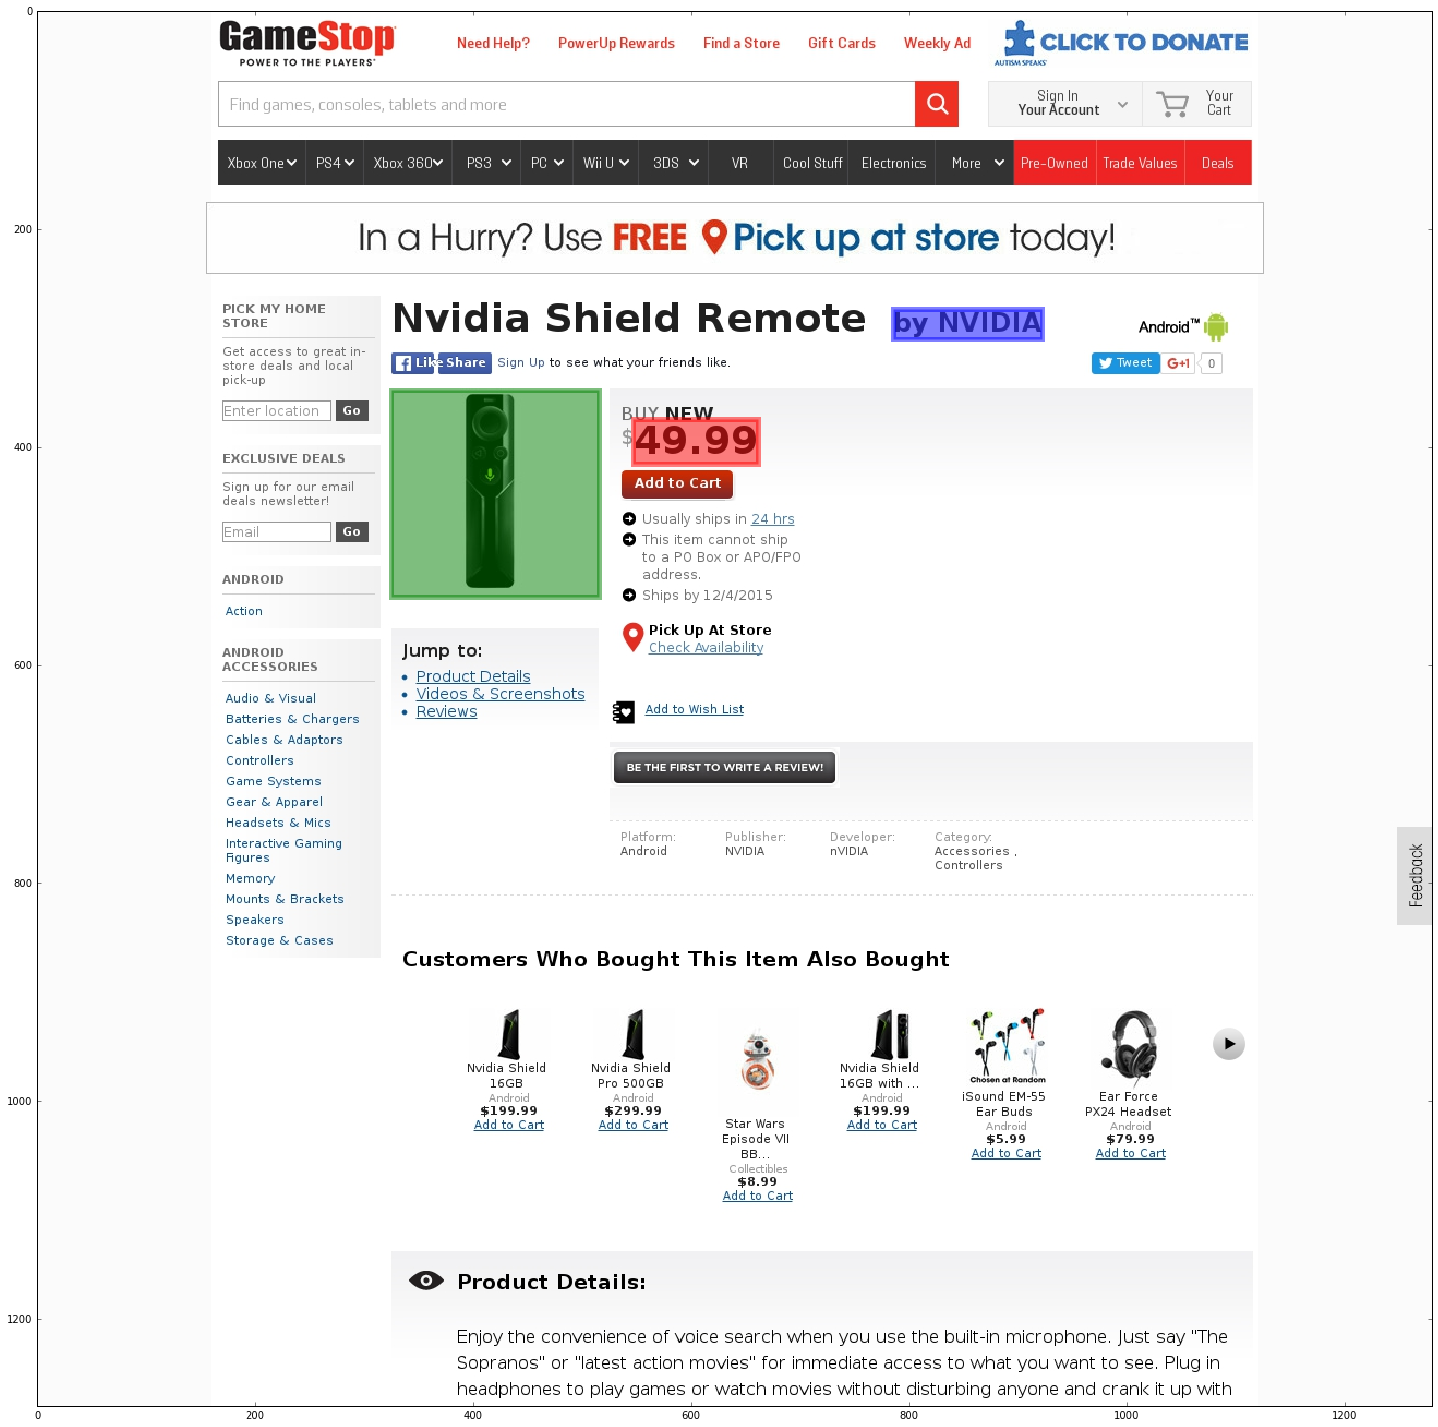

In [26]:
def display_selection():
    selected_layer = layer_selector.value
    selected_neuron = neuron_slider.value
 
    # display convolutions
    display_conv_activations(selected_layer, selected_neuron)
      
def show_result():
    display_results(display_input_boxes_checkbox.value,False,
                    display_classified_checkbox.value, display_with_position_checkbox.value)
    
########### LAYER SELECTOR ###########
def handle_layer_change():
    selected_layer = layer_selector.value
    #update neuron slider
    neuron_slider.max = len(net.blobs[selected_layer].data[0])-1 
    #display
    display_selection()

layers_to_select = [layer for layer in net.blobs.keys()] 

layer_selector = widgets.Dropdown(
    options=layers_to_select,
    description='Select layer:',
)

layer_selector.on_trait_change(handle_layer_change, name="value")

######### NEURON SLIDER ###########
def handle_neuron_change():
    display_selection()

neuron_slider = widgets.IntSlider(
    min=0,
    max=len(net.blobs[layer_selector.value].data[0])-1,
    description='Select neuron:',
)

neuron_slider.on_trait_change(handle_neuron_change, name="value")

######### NEXT BUTTON ###########
def click(b):
    next_image()
    show_result()

next_button=widgets.Button(description='Next Image')
next_button.on_click(click)
    
######### DISPLAY CLASSIFIED CHECKBOX  #############
def handle_display_classified_change():
    show_result()

display_classified_checkbox = widgets.Checkbox(
    description='Display all classifications:',
    value=False,
)
display_classified_checkbox.on_trait_change(handle_display_classified_change, name="value")

######### DISPLAY INPUT BOXES CHECKBOX  #############
def handle_display_input_boxes_change():
    show_result()

display_input_boxes_checkbox = widgets.Checkbox(
    description='Display input boxes:',
    value=False,
)
display_input_boxes_checkbox.on_trait_change(handle_display_input_boxes_change, name="value")

######### WITH POSITION CHECKBOX  #############
def handle_display_with_position_change():
    show_result()

display_with_position_checkbox = widgets.Checkbox(
    description='Display with position likelihood:',
    value=False,
)
display_with_position_checkbox.on_trait_change(handle_display_with_position_change, name="value")

########## ADD TOGLES ##########
disp.display()
disp.display(next_button)
disp.display(layer_selector)
disp.display(neuron_slider)
disp.display(display_classified_checkbox)
disp.display(display_input_boxes_checkbox)
disp.display(display_with_position_checkbox)

roi_pool
(96, 7, 7)


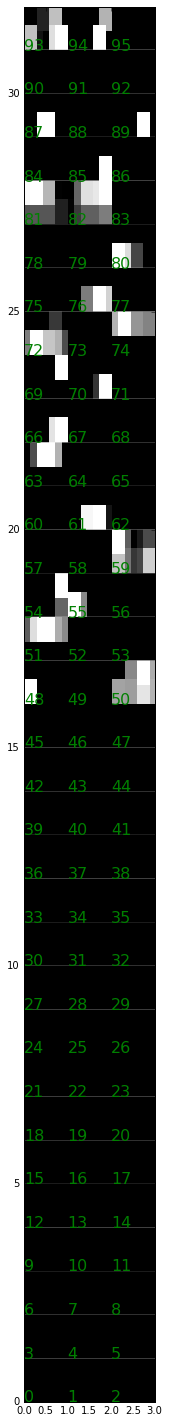

In [119]:
show_activation('roi_pool')

In [107]:
# #$ = 5
# #number = 29
# def txt_stats_in_box(txt_layer, box_id):
box_id=0
selected_txt_layer = 5

predicted = net.blobs['prob'].data[:,0:4,0,0]  #(n_boxes,n_classes)
boxes = net.blobs['boxes'].data[:,1:5]
txt_data = net.blobs['txt_data'].data[0,:,:,:]
txt_in_layer = txt_data[txt_layer,:,:]

print 'ENLARGED TEXT MAPS:'
act_x_ratio =  1280/txt_in_layer.shape[1]
act_y_ratio =  1280/txt_in_layer.shape[0]
    
enlarged_txt_in_layer = np.kron(txt_in_layer, np.ones((act_y_ratio,act_x_ratio)))

box = boxes[box_id,:]
enlarged_txt_in_box = enlarged_txt_in_layer[box[1]:box[3],box[0]:box[2]]

print 'BOX POSITION:',box
print 'BOX SIZE:', box[2]-box[0],'x',box[3]-box[1]
print 'Text in box', np.mean(enlarged_txt_in_box)/255
print '---------------------'


scale =  0.125 #0.0625
scaled_box = [int(round(b*scale)) for b in box]
txt_in_box = txt_in_layer[scaled_box[1]:scaled_box[3],scaled_box[0]:scaled_box[2]]

print 'SCALED DOWN BOX:'
print 'BOX POSITION:', scaled_box
print 'BOX SIZE INPUT:', scaled_box[2]-scaled_box[0],'x',scaled_box[3]-scaled_box[1]
print 'BOX SIZE IN FINAL POOL:', (scaled_box[2]-scaled_box[0])/2,'x',(scaled_box[3]-scaled_box[1])/2
print 'Text in box', np.mean(txt_in_box)/255

print '------------------'

print txt_in_box/255

print '------------------'
print 'NON-ZERO TEXT LAYERS'
for layer in range(128):
    txt_in_layer = txt_data[layer,:,:]
    txt_in_box = txt_in_layer[scaled_box[1]:scaled_box[3],scaled_box[0]:scaled_box[2]]
    
    if np.sum(txt_in_box)>0:
        print layer



ENLARGED TEXT MAPS:
BOX POSITION: [ 903.  386.  971.  435.]
BOX SIZE: 68.0 x 49.0
Text in box 0.624766602413
---------------------
SCALED DOWN BOX:
BOX POSITION: [113, 48, 121, 54]
BOX SIZE INPUT: 8 x 6
BOX SIZE IN FINAL POOL: 4 x 3
Text in box 0.707106825885
------------------
[[ 0.70710677  0.70710677  0.70710677  0.70710677  0.70710677  0.70710677
   0.70710677  0.70710677]
 [ 0.70710677  0.70710677  0.70710677  0.70710677  0.70710677  0.70710677
   0.70710677  0.70710677]
 [ 0.70710677  0.70710677  0.70710677  0.70710677  0.70710677  0.70710677
   0.70710677  0.70710677]
 [ 0.70710677  0.70710677  0.70710677  0.70710677  0.70710677  0.70710677
   0.70710677  0.70710677]
 [ 0.70710677  0.70710677  0.70710677  0.70710677  0.70710677  0.70710677
   0.70710677  0.70710677]
 [ 0.70710677  0.70710677  0.70710677  0.70710677  0.70710677  0.70710677
   0.70710677  0.70710677]]
------------------
NON-ZERO TEXT LAYERS
5
29


/auto/plzen1/home/gogartom/jupyter/lib/python2.7/site-packages/ipykernel/__main__.py:19: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


# Layer visualization

In [114]:
########### LAYER SELECTOR 2 ###########\n",
def handle_layer_change_2():
    selected_layer = layer_selector_2.value
    show_activation(selected_layer)
        
        
#### LAYER selector
layers_to_select_2 = [layer for layer in net.blobs.keys() if (('rois' not in layer) and 
                                                              ('fc' not in layer) and ('pred' not in layer))]

layer_selector_2 = widgets.Dropdown(
    options=layers_to_select_2,
    description='Select layer:',)

layer_selector_2.on_trait_change(handle_layer_change_2, name="value")
disp.display(layer_selector_2)